<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Identificación de huellas de calzado a partir de imágenes con redes neuronales convolucionales </p>
<p style="margin: 0; text-align:right;">MU Ingeniería Computacional y Matemática / Área de Inteligencia Artificial</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Laura Rivera Sanchez</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>



# Identificación de huellas de calzado a partir de imágenes con redes neuronales convolucionales 

Falta resumen

In [184]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
import random
import skimage

In [121]:
#from google.colab import drive
#drive.mount('/content/gdrive')

# Lectura y análisis de los conjuntos de datos






## Base de datos 2d FootWear con información de marca

In [ ]:
#df_2dfootwear = pd.read_csv('data/2dFootwear/Data-information.csv', delimiter=';')

with ZipFile('data/2dFootwear/Part1.zip', 'r') as zipObj:
  zipObj.extractall('images')

with ZipFile('data/2dFootwear/Part2.zip', 'r') as zipObj:
  zipObj.extractall('images')



In [ ]:
with ZipFile('data/2dFootwear/Part3.zip', 'r') as zipObj:
  zipObj.extractall('images')

with ZipFile('data/2dFootwear/Part4.zip', 'r') as zipObj:
  zipObj.extractall('images')

with ZipFile('data/2dFootwear/Part5.zip', 'r') as zipObj:
  zipObj.extractall('images')

**Análisis de los datos 2d Footwear**
(Explicar)

In [122]:
df = pd.read_csv('data/2dFootwear/Data-information.csv', delimiter=';')
df['Brand'] = df['Brand'].str.strip() #eliminar espacios en blanco
X_files = df['ID'].values.tolist()
brands = df['Brand'].values.tolist()

values_brand, counts_brand = np.unique(brands, return_counts=True)
print('Tag example:',X_files[0]) #nomenclatura 
print('Nº lines:',len(X_files)) #lineas en el csv
individuals, count_ind = np.unique(df['ID'].str[:3], return_counts=True)
print('Nº different people:',len(individuals)) #diferentes individuos de la muestra
num_classes = len(values_brand) #se guarda porque será necesario para crear el modelo
print('Nº of different brands: %d' %num_classes) #marcas diferentes
print(values_brand) #Listado de marcas únicas



Tag example: 001_01
Nº lines: 150
Nº different people: 28
Nº of different brands: 60
['Adidas' 'Airspeed' 'Airwalk' 'Aldo' 'American Eagle' 'Arizona' 'Asics'
 'BAGO' 'BASS' 'Birkenstock' 'Brooks' 'CalvinKlain' 'Champion' 'Clarks'
 'Columbus' 'Converse' 'Cooeli' 'Court classic' 'Dansko' 'Deer Stags'
 'Dockers' 'Ecco' 'Elcanto' 'Fadedglory' 'Feiyue' 'Fila' 'G.H.Bass&Co'
 'Guho' 'HeyBear' 'K-swiss' 'Keen' 'Landya' 'Namuhana' 'Newbalance' 'Nike'
 'Ninewest' 'None' 'OP' 'Ofem' 'Prospecs' 'Puma' 'Robin' 'Saucony'
 'Shoedy' 'Shoopen' 'Simply vera' 'Skechers' 'Soma' 'Sonoma' 'Sorel'
 'Sperry' 'Stone' 'Sugar' 'T2R' 'Teva' 'Truesoft' 'Under Amour' 'Vans'
 'Vibram' 'Yonex']


A continuación, el histograma con el número de muestras según género, en este caso hay 70 muestras de mujeres y 80 de hombres.

(array([71.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 79.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

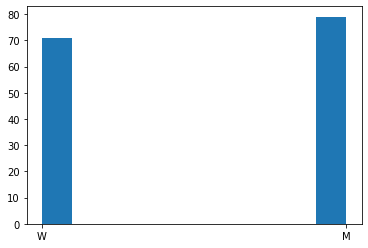

In [4]:
plt.hist(df['Gender'])

Por último, se muestran las cinco marcas que más aparecen en el conjunto de datos. \
Además se seleccionan esas marcas que aparecen minimo 2 veces en la muestra, para crear un subconjunto de datos que elimine las marcas con una única muestra y comprobar en los siguientes casos si influye en el resultado.


Brands with more than 1 register: 19
Brands with only 1 register: 40


<AxesSubplot: xlabel='x'>

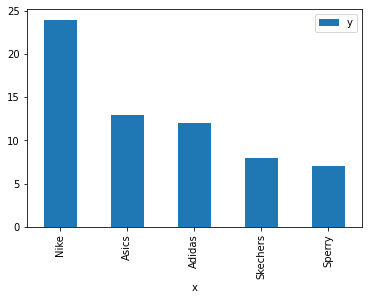

In [123]:


dfbrand = pd.DataFrame({'x':values_brand, 'y':counts_brand}) 
dfbrand = dfbrand.sort_values('y', ascending = False) #ordenar descendientemente

#Eliminar los que tengan "None" como marca:
dfbrand=dfbrand[dfbrand['x']!="None"]
#eliminar los que tengan menos de 2 muestras:
dfbrandone=dfbrand[dfbrand['y']<2]
dfbrand=dfbrand[dfbrand['y']>=2]
num_classes=len(dfbrand)
print('Brands with more than 1 register: %d' %num_classes) #quedan 20 marcas
print('Brands with only 1 register: %d' %len(dfbrandone)) #quedan 20 marcas
dfbrand = dfbrand.head(5) # mostrar las 5 marcas que más aparecen en el conjunto de datos
dfbrand.plot('x', 'y', kind='bar') #mostrar gráfica



In [124]:



def get_images_to_jpeg(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []

  for f in dir_list:

    im = Image.open("./"+imgPath+"/"+f)
    im2=im.resize((400,912))
    im3 = im2.crop((40,40,320,872)) #Quitar marco medidor
    im3.save("./"+imgPath+"/"+f[0:-4]+'jpeg')
    
    result.append(f[0:-4]+'jpeg')
    os.remove("./"+imgPath+"/"+f)

  print('Nº files:',len(result))
  return result

def get_images(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []
  for f in dir_list:  
    result.append(f)


  print('Nº files:',len(result))
  return result

In [125]:
# Get the list of all files in /images and convert to jpeg
#shoeFiles = get_images_to_jpeg("images") #la primera vez para convertir las imágenes
shoeFiles = get_images("images")

Nº files: 1500


## Base de datos Datos FD-300


In [ ]:
#Extracción de los ficheros del zip
with ZipFile('data/FID300/images.zip', 'r') as zipObj:
  zipObj.extractall('fid300')




In [ ]:
#Lectura de la tabla de resultados
df_fid300 = pd.read_csv('data/FID300/label_table.csv', delimiter=',')

En este caso, las imágenes estan divididas en 3 carpetas:

*   *tracks_original*: Conteine las 300 imágenes originales extraidas de la escena del crimen, incluyendo la plantilla de medición.
*   *tracks_cropped*: Contiene las imágenes originales pero ya recortadas.
*  *references*: Contiene las 1175 imágenes de las huellas de referencia, obtenidas de diferentes calzados.

Para el proyecto se decide utilizar las dos últimas categorias, guardandolas en 2 datasets diferenciados: *fid300ref* y *fid300crop*.


**Análisis de los datos FD-300**



In [ ]:
fid300ref = get_images("fid300/references")
fid300crop = get_images("fid300/tracks_cropped")

print(len(df_fid300)) #lineas en el csv
print(fid300ref[0])

In [ ]:

X_files = df_fid300['X'].values.tolist()
y = df_fid300['y'].values.tolist()

values_y, counts_y = np.unique(y, return_counts=True)

print('Nº of references: %d' %len(values_y))

dfref = pd.DataFrame({'x':values_y, 'y':counts_y}) 
dfref = dfref.sort_values('y', ascending = False) 
dfref.head(10) # coger los 5 primeros



**Visualización de imágenes**\
Se ha creado la función *plot_image* que permite la visualización de las imágenes de cualquiera de las dos bases de datos.

Parámetros:\
*imgPath*: carpeta donde estan las imágenes \
*fileNames*: array con los nombres de los ficheros a mostrar


In [ ]:

import skimage
def plot_image(imgPath, fileNames):
  for i in range(len(fileNames)):
    filename = fileNames[i]
    img = skimage.io.imread(imgPath+filename)
   
    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img)
  print(fileNames)
  plt.show()


A continuación, se muestra una imagen aleatória de cada uno de los 3 datasets del proyecto:

In [ ]:
plot_image("images/",random.choices(shoeFiles,k=1))

In [ ]:



plot_image("fid300/references/",random.choices(fid300ref,k=1))
plot_image("fid300/tracks_cropped/",random.choices(fid300crop,k=1))

#import cv2 as cv
#from google.colab.patches import cv2_imshow 
#image = cv.imread("images/"+shoeFiles[0]) #leo la primera imagen de train
#cv2_imshow(image) #mostrar


## División de los datos

Para la división de los datos se ha utilizado la funcióon train_test_split dos veces, primero para dividir entre el 80% de train y el 20% de test y después para extraer el equivalente al 10% para la validación. 

De esta manera se dispone de 70% train, 20% test y 10% validación.


Antes de dividir los datos de la base de datos 2d Footwear, se ha formateado la tabla ya que actualmente solo muestra la información de marca según el calzado del usuario, pero no contiene el nombre de la imagen, se ha creado la siguiente función para que el conjunto de datos contenga dos columnas (X:fichero, y:marca)

In [145]:
def filesWithBrand(shoeFiles):
  files = []
  brands = []
  for image in shoeFiles:
    files.append(image) #filename
    person = df[df['ID'].str[:6]==image[:6]]  #persona+contador de calzado
    brands.append(person['Brand'].iloc[0])

  return pd.DataFrame({'X':files, 'y':brands}) 


df_shoe_brand = filesWithBrand(shoeFiles)
#eliminar aquellas marcas que no aparecen mínimo en 2 muestras 
df_shoe_brand=df_shoe_brand[~df_shoe_brand['y'].isin(dfbrandone['x'].to_numpy())]
df_shoe_brand=df_shoe_brand[df_shoe_brand['y']!="None"]
df_shoe_brand['factor_brand'] = pd.Categorical(pd.factorize(df_shoe_brand['y'])[0].astype(np.float32))
print(df_shoe_brand)
#número de marcas con 2 o más muestras:
print(num_classes)

                     X         y factor_brand
0     021_05_R_03.jpeg  Champion          0.0
2     026_06_R_01.jpeg      Keen          1.0
3     009_08_R_05.jpeg     Asics          2.0
7     012_04_L_01.jpeg  Prospecs          3.0
8     010_01_L_01.jpeg  Skechers          4.0
...                ...       ...          ...
1493  011_01_R_04.jpeg    Adidas          8.0
1494  026_07_L_03.jpeg   Saucony         13.0
1496  018_04_R_02.jpeg    Sperry          6.0
1497  012_05_R_03.jpeg  Namuhana         16.0
1499  025_03_L_04.jpeg      Nike          9.0

[1070 rows x 3 columns]
19
19


In [208]:
from sklearn.model_selection import train_test_split
def  split_datafiles(df):
  X_train, X_test = train_test_split(df, test_size=0.2 , random_state=random.randint(0,32),shuffle=True)

  X_train, X_val = train_test_split(X_train, test_size=0.14, random_state=random.randint(0,32),shuffle=True) # 0.14 x 0.7 = 0.1
  return X_train,  X_test ,X_val

#Dividir conjunto de datos:
#shoes_train, shoes_test, shoes_val = split_datafiles(df)
shoes_train, shoes_test, shoes_val = split_datafiles(df_shoe_brand)

In [ ]:
#división de los datos FD300



# Objetivo 1: Predicción de la marca de calzado 

Para este apartado se van a utilizar diferentes clasificadores para comparar su resultado.
Además de crear una red neuronal para el mismo objetivo, y así podem comparar qué método obtiene mejores resultados.

En el caso de la red neuronal, además, se añadiran diferentes procesos para ver si mejoran el modelo:

- Augmentación en los datos.
- Uso del modelo preentrenado RestNet.
- Uso de autokeras para determinar si encuentra mejor modelo que el propuesto.



## Extracción de características

La extracción de características es el proceso de recuperar los datos más importantes de los datos sin procesar. La extracción de características es encontrar el conjunto de parámetros que definen la forma de una imagen de manera precisa y única.

Para la extracción de características se utiliza la técnica Bag of Features, que extrae N características de las imágenes utilizando los descriptores SIFT (Scale Invariant Feature Transform).

Existen diferentes algoritmos de extracción de caraterísticas: 
- **SIFT (Scale Invariant Feature Transform)**
- SURF https://docs.opencv.org/3.4/df/dd2/tutorial_py_surf_intro.html, 
- KAZE, 
- ORB.

Todos ellos estan disponibles en la librería openCV y para este proyecto se escoge utilizar SIFT ya que KAZE y ORB tienen cuenta las rotaciones y en este caso no sería necesario, ya que todas las muestras se toman con la misma metodologia.


Aqui nombre diferentes descriptores, además de SIFT:
https://www.sciencedirect.com/science/article/pii/S0379073821004461

In [92]:
!pip install opencv-contrib-python==4.4.0.44 

In [93]:
#extrae y calcula los descriptores SIFT para el conjunto de imágenes enviado
def extractSIFT(input_files):
    all_features_dict = {}
    feature_extractor = cv.SIFT.create()
    for i, fname in enumerate(input_files):
        rgb = cv.cvtColor(cv.imread("images/"+fname), cv2.COLOR_BGR2RGB)
        gray = cv.cvtColor(rgb, cv.COLOR_RGB2GRAY)
        kp, desc = feature_extractor.detectAndCompute(gray, None)
        all_features_dict[fname] = desc
    return all_features_dict

In [94]:
#Esta función extrae las características de cada categoria (marca)
#input: listado de categorias (marcas), listado de ficheros, marca de cada fichero
#output: lista ficheros, lista categorias, lista de características
def getFiles(cat_list, X_files, y_values):
  all_files = []
  all_files_labels = {}
  all_features = {}
  cat_indexes= []
  cat_files = []
  cat_features = []

  #values_train contiene el listado de categorias sin repeticiones 
  for cat, label in zip(cat_list, range(len(cat_list))):
      
      #primero buscar los indices en el listado de cada categoria (dentro bucle)
      cat_indexes = [i for i,x in enumerate(y_values) if x == cat]
      
      #como se saben las posiciones, se cogen esas imagenes de esa categoria:
      cat_files = [X_files.iloc[i] for i in cat_indexes]
      cat_features = extractSIFT(cat_files)
      all_files = all_files + cat_files
      all_features.update(cat_features)
      for i in cat_files:
          all_files_labels[i] = label
  return all_files, all_files_labels, all_features

Bag of features

https://www.researchgate.net/publication/260952140_A_Detailed_Review_of_Feature_Extraction_in_Image_Processing_Systems

https://www.sciencedirect.com/topics/engineering/feature-extraction

https://www.naun.org/main/NAUN/bio/bio-2.pdf

In [95]:
import cv2 as cv
import pickle

def getFilesBySubset(subset, tipo):
    #values_brand= np.unique(subset['y']) #listado marcas únicas que aparecen en subconjunto TRAIN

    if os.path.exists("saved/all_files_nonone_"+tipo+".pkl"):
        with open('saved/all_files_nonone_'+tipo+'.pkl', 'rb') as fp:
            all_files = pickle.load(fp)
        with open('saved/all_files_nonone_labels_'+tipo+'.pkl', 'rb') as fp:
            all_files_labels = pickle.load(fp)
        with open('saved/all_features_nonone_'+tipo+'.pkl', 'rb') as fp:
            all_features = pickle.load(fp)
        #all_files_train = np.loadtxt('saved/all_files_train.txt')
        #all_files_labels_train = np.loadtxt('saved/all_files_labels_train.txt')
        #all_features_train = np.loadtxt('saved/all_features_train.txt')
    else:
        all_files, all_files_labels, all_features=getFiles(values_brand,subset['X'],subset['y'])

    return all_files, all_files_labels, all_features


In [97]:
values_brand= np.unique(df_shoe_brand['y']) #listado marcas únicas que aparecen en subconjunto TRAIN

all_files_train, all_files_labels_train, all_features_train=getFilesBySubset(shoes_train, "train")
#Este proceso tarda 40 minutos aproximadamente, por eso se guarda en un fichero para agilizar las pruebas

In [98]:

if not os.path.exists("saved/all_files_nonone_train.pkl"):
    with open('saved/all_files_nonone_train.pkl', 'wb') as fp:
        pickle.dump(all_files_train, fp)
    with open('saved/all_files_labels_nonone_train.pkl', 'wb') as fp:
        pickle.dump(all_files_labels_train, fp)
    with open('saved/all_features_nonone_train.pkl', 'wb') as fp:
        pickle.dump(all_features_train, fp)
        

A continuación un ejemplo de la matriz de características y la impresión de la imagen con los puntos puntos de interés detectados.

TODO: recortar la imagen, ya que los medidores de alrededor no aportan información de marca.

In [99]:
#guarda la primera imagen  con los puntos de interés
img = cv.imread("images/"+all_files_train[0])
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

features = cv2.SIFT_create()
keypoints = features.detect(gray, None)

img2=cv.drawKeypoints(gray,keypoints,0,(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite('results/'+all_files_train[0], img2)



True

In [100]:
#Se crea el Bag of Features con un diccionario de tamaño 75:
dictionarySize =75
if not os.path.exists("saved/bow_dict_nonone.pkl"):
    
    BOW = cv.BOWKMeansTrainer(dictionarySize)

    for feat in all_features_train:
        BOW.add(all_features_train[feat])
    dictionary = BOW.cluster()
else:
    with open('saved/bow_dict_nonone.pkl', 'rb') as fp:
        dictionary = pickle.load(fp)
print(dictionary.shape)
print(all_features_train[all_files_train[0]].shape) #subdivisión de train: shoes_train

(75, 128)
(1219, 128)


In [101]:
import pickle
if not os.path.exists("saved/bow_dict_nonone.pkl"):
    with open('saved/bow_dict_nonone.pkl', 'wb') as fp:
        pickle.dump(dictionary, fp)
        print('BOW dictionary saved successfully to file')
        
#Como se trata de un proceso que toma bastante tiempo, también se ha decidido guardar el resultado en un fichero para futuras ejecuciones

BOW dictionary saved successfully to file


In [102]:
def getFeatures(all_files, all_features, all_files_labels):
  X = np.empty((len(all_files),dictionarySize))
  y = np.empty((len(all_files),))
  all_features_BOW = {}

  count = 0
  for filename in all_files:
      desc_query = all_features[filename]
      matches = matcher.match(desc_query,dictionary)
      train_idxs = []
      for j in range(len(matches)):
        train_idxs.append(matches[j].trainIdx)
      hist, bin_edges = histogram(train_idxs, bins=range(dictionarySize+1))
      all_features_BOW[filename] = hist
      X[count,:] = hist
      y[count] = all_files_labels[filename]
      count = count + 1
  return X,y

In [103]:
from numpy import histogram
import numpy as np

#Comentario: A continuación se normaliza el numero de caracteristicas para que todas tengan la misma cantidad,
#ya que con el proceso anterior (BOW) es muy probable que las imagenes tengan numero de caracteristicas diferentes.

matcher = cv.BFMatcher(normType=cv.NORM_L2)

X, y = getFeatures(all_files_train, all_features_train, all_files_labels_train)


### Support Vector Machines (SVM)

TODO: Descripción

In [104]:

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV

X_train, X_test_t, y_train, y_test_t = train_test_split(X, y, test_size=0.3, random_state=0)

# Set the parameters by cross-validation
kernels =  ["rbf", "linear", "poly", "sigmoid"]
Cs= [1, 2,3,4, 5, 10, 20]


#Se utiliza GridSearchCV para identificar la mejor configuración de entre los diferentes kernel con diferentes
#valores de C.
clf = GridSearchCV(estimator=svm.SVC(), param_grid=dict(C=Cs, kernel=kernels),n_jobs=-1)
clf.fit(X_train, y_train)

print('Mejor configuración kernel=%s, c= %s con un score de %s' %(clf.best_estimator_.kernel, clf.best_estimator_.C, clf.best_score_))

Mejor configuración kernel=rbf, c= 20 con un score de 0.9735309973045823


In [105]:
#Ejecuto la configuración con mejor resultado kernel=rbf, c=20:

clf_train = svm.SVC(kernel='rbf', C=20).fit(X_train, y_train)
clf_train.score(X_test_t, y_test_t)

0.960352422907489

In [106]:
all_files_test, all_files_labels_test, all_features_test=getFilesBySubset(shoes_test, "test")
X, y = getFeatures(all_files_test, all_features_test, all_files_labels_test)

clf_train.score(X,y)


0.9727272727272728

In [107]:
#Resultado de la predicción:
from sklearn.metrics import accuracy_score
print(accuracy_score(y, result))
#print(confusion_matrix(y,result))

NameError: name 'result' is not defined

In [ ]:
#print(shoes_test.iloc[3])
#print(prediction[3])

### KNeighborsClassifier

TODO: Descripción

In [108]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=num_classes)
model.fit(X_train, y_train)
model.score(X_test_t, y_test_t)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:189: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.5682819383259912

In [109]:
#partición de test
model.score(X,y)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:189: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.6318181818181818

### DecisionTreeClassifier

Explicación
TODO: Descripción

In [110]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
model.score(X_test_t, y_test_t)

0.7092511013215859

In [111]:
#partición de test
model.score(X,y)

0.6727272727272727





## Red neuronal de clasificación de imágenes por Marca (2d Footwear)

En este caso los datos ya estan etiquetados, por lo que se puede crear un modelo para que entrene según esa etiqueta. 


*Es necesario transformar las etiquetas de marcas a numérico para el correcto funcionamiento del modelo. Paso realizado en los primeros pasos*





In [227]:
#Se ha creado un generador para añadir la aumentación de las imágenes
import torchvision.io
import torch
from tensorflow.keras.utils import Sequence
import torchvision.transforms as T
from torchvision.transforms import Resize
from skimage.io import imread
from skimage.util import img_as_float,random_noise
from skimage.transform import rotate
import numpy as np
import random
import os
from skimage import io
from skimage import transform, util


def create_variation(theImage,doFlip,doNoise,doRotate):
  image = img_as_float(theImage)
  if doFlip==True:
    image = np.fliplr(image)
  if doNoise==True:
    image = util.random_noise(image)
  if doRotate==True:
    image = transform.rotate(image, random.randint(-45, 45),mode='symmetric')
  return image

class DataGenerator2dFootwear(Sequence):
    # Constructor. Input parameters are:
    # * fileNames   : List of sample file names
    # * doRandomize : If True, the provided file names are shuffled after each training epoch
    #                 and each image can be left unchanged, flipped, corrupted with
    #                 noise or rotated. 8 possible combinations is chosen randomly with equal probability.
    #                 If False, file names are not shuffled and each image is provided unchanged.
    # * imgPath     : Path to the images 
    # * batchSize   : Number of sample images and ground truth items in each batch
    def __init__(self,data,doRandomize=False,imgPath='images',batchSize=10):
        # Store parameters
        self.imgPath=imgPath
        self.fileNames=data.copy()
        self.batchSize=batchSize
        self.doRandomize=doRandomize
        # Get number of files (to avoid computing them later)
        self.numImages=len(data)
        # Shuffle them if required
        self.on_epoch_end()

    # Shuffle data if required
    def on_epoch_end(self):
        if self.doRandomize:
            random.shuffle(self.fileNames)

    # Returns the number of total batches
    def __len__(self):
        return int(np.ceil(float(self.numImages)/float(self.batchSize)))

    
    # Input  : theIndex - Index of the image to load within self.fileNames.
    # Output : theImage - Loaded (and possibly transformed) image. Must be
    #                     of float type with values within [0,1]
    #          theClass - Shoe brand
    def _load_image_(self,theIndex):

   
        file = self.fileNames[theIndex]  
        
        img = io.imread(self.imgPath+file)

        image = torchvision.io.read_image(self.imgPath+file, torchvision.io.ImageReadMode.GRAY)
        #image = torchvision.transforms.CenterCrop(image,[832, 280]) No need
        
        #scale = T.ConvertImageDtype(torch.float32)
        #theImage = scale(img)
        theImage = img_as_float(img) #dos maneras de hacer el float32, ¿alguna mejor que la otra?
        
        theImage=theImage /255.0 #normalizar

        #añadir aumentación a las imágenes:
        if self.doRandomize:
          theImage=create_variation(img,random.choice([True, False]),random.choice([True, False]),random.choice([True, False])) 
        #else:
         # theImage=create_variation(img,False, False, False)

        #Buscar la imagen en el csv para extraer la Marca:
        person = df_shoe_brand[df_shoe_brand['X'].str[:6]==file[:6]]  #persona+contador de calzado
        theClass = person['factor_brand'].iloc[0]#self.classes[theIndex] #¿debe ser numérico o podría ser la etiqueta?

        return theImage,theClass

    # Provides the images,class batch
    # Batch format:
    # - X : The data. Numpy array of shape (bs,nr,nc,3)
    # - y : The ground truth. Numpy array of shape (bs,1)
    # Where nb=batch size, nr=num rows, nc=num cols
    def __getitem__(self,theIndex):
        X=[]
        y=[]
        bStart=max(theIndex*self.batchSize,0)
        bEnd=min((theIndex+1)*self.batchSize,self.numImages)
        for i in range(bStart,bEnd):
            [curImage,curGT]=self._load_image_(i)
            X.append(curImage)
            y.append(curGT)
        return np.array(X),np.array(y)
    
    


In [113]:
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Softmax
from tensorflow.keras import optimizers

# Función que crea el modelo:
def create_2dfootwear_model1():
    theModel=models.Sequential([
        Conv2D(32,(3,3),activation='relu',input_shape=(832, 280,3)), #tamaño imagen reducida antes
        MaxPooling2D((2,2),padding='same'),
        
        Conv2D(32,(3,3),activation='relu'),
        MaxPooling2D((2,2),padding='same'),   
        Flatten(),
        Dense(128, activation="relu"),
        

        Dense(num_classes+1,activation='relu'),
        Dense(activation='softmax')
        Flatten()
    ])
          


    return theModel

theModel=create_2d_footwear_model1()
theModel.summary()

#Este modelo no se utiliza, se utiliza el siguiente

SyntaxError: invalid syntax (<ipython-input-113-699a0777a3de>, line 19)

In [310]:
#Modelo utilizado:

from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Softmax, Rescaling, Dropout
import tensorflow as tf
model_test = models.Sequential([
  #Rescaling(1./255, input_shape=(280,832,3)),
  Conv2D(16, 3, padding='same', activation='relu', input_shape=(280,832,3)),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(0.5),
  Dense(num_classes, activation='softmax')
  #Dense(num_classes,activation='softmax')
  # ,Flatten()
])



In [311]:
model_test.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 280, 832, 16)      448       
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 70, 208, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 70, 208, 64)       18496     
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 35, 104, 64)    

In [31]:
#Modelo mejorado (TODO):


In [312]:
#Se han testeado diferentes optimizadores, se escoge ADAM.
#Optimizador ADAM
model_test.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [264]:
#Optimizador SGD
from keras.optimizers import SGD
opt = SGD(learning_rate=0.01, momentum=0.8)
model_test.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'],optimizer = opt)

In [ ]:
#RMSprop
opt = optimizers.RMSprop(learning_rate=0.0001)
model_test.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [141]:
print(shoes_train)

                     X           y factor_brand
1149  012_02_R_05.jpeg       Sorel         15.0
1394  012_10_R_05.jpeg        Teva          8.0
823   024_01_R_01.jpeg       Asics          2.0
1431  006_04_R_04.jpeg      Adidas          9.0
238   013_01_R_05.jpeg  Newbalance         12.0
...                ...         ...          ...
1338  011_01_L_03.jpeg      Adidas          9.0
456   019_03_R_01.jpeg        Nike         10.0
86    017_04_R_05.jpeg    Namuhana         17.0
1173  002_01_L_03.jpeg     Saucony         14.0
1262  021_02_L_01.jpeg    Champion          0.0

[756 rows x 3 columns]


In [313]:
trainGenerator=DataGenerator2dFootwear(shoes_train['X'].tolist(),True, "images/")
testGenerator=DataGenerator2dFootwear(shoes_test['X'].tolist(),False, "images/")
valGenerator=DataGenerator2dFootwear(shoes_val['X'].tolist(),False, "images/")

trainGenerator.__getitem__(0)[0].shape



(10, 832, 280, 3)

In [314]:
trainHistory = model_test.fit(trainGenerator,validation_data=valGenerator, epochs=10)

Epoch 1/10
74/74 [==============================] - 93s 1s/step - loss: 3.6289 - accuracy: 0.1644 - val_loss: 2.6673 - val_accuracy: 0.2333
Epoch 2/10
74/74 [==============================] - 87s 1s/step - loss: 2.6984 - accuracy: 0.2147 - val_loss: 3.7688 - val_accuracy: 0.2333
Epoch 3/10
74/74 [==============================] - 87s 1s/step - loss: 2.4999 - accuracy: 0.2228 - val_loss: 5.5866 - val_accuracy: 0.0833
Epoch 4/10
74/74 [==============================] - 86s 1s/step - loss: 2.2891 - accuracy: 0.3016 - val_loss: 8.5272 - val_accuracy: 0.0833
Epoch 5/10
74/74 [==============================] - 87s 1s/step - loss: 2.0572 - accuracy: 0.3709 - val_loss: 9.4853 - val_accuracy: 0.0833
Epoch 6/10
74/74 [==============================] - 87s 1s/step - loss: 1.8105 - accuracy: 0.4497 - val_loss: 8.6203 - val_accuracy: 0.0833
Epoch 7/10
74/74 [==============================] - 86s 1s/step - loss: 1.6366 - accuracy: 0.4946 - val_loss: 10.2719 - val_accuracy: 0.0833
Epoch 8/10
74/74 [=

In [278]:

def plot_history(history):
# summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_history_2(history):
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

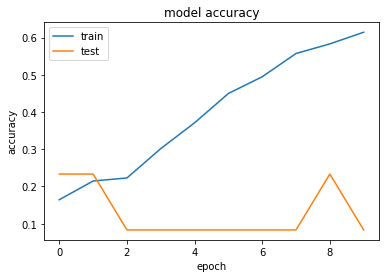

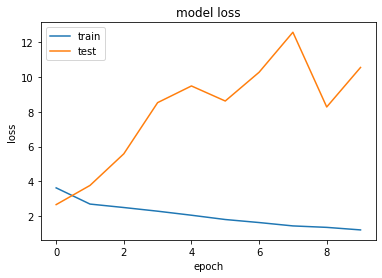

In [315]:
plot_history(trainHistory)

In [316]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
predicted_y = model_test.predict(testGenerator)
# Evaluate the best model with testing data.
#print(confusion_matrix(shoes_test['y'],predicted_y))



22/22 [==============================] - 7s 289ms/step


In [317]:
model_test.evaluate(testGenerator)

22/22 [==============================] - 6s 276ms/step - loss: 11.1161 - accuracy: 0.0748


[11.116055488586426, 0.07476635277271271]

In [318]:
def showResult(predicted, test, array):
    filename = test['X']
    img = skimage.io.imread("images/"+filename)
   
    plt.figure()
    plt.title(test['y']+" "+str(test['factor_brand']))
    plt.imshow(img)
    if array == True:
        sort_index = np.argsort(predicted)
        print(sort_index)
    else:
        print(predicted)

    
  

[18 10 13 17 14 15 12 16  7  5  2  6  1  8 11  0  9  3  4]


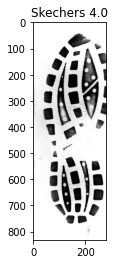

In [319]:

showResult(predicted_y[0],shoes_test.iloc[0], True)

In [345]:
#Calular porcentaje que aparecen en las 3 primera posiciones 

def get3firstOk(predicted, test):
    sort_index = np.argsort(predicted)
    if test['factor_brand'] in sort_index[:3]:
        return True
    return False
        

In [349]:
def checkAccuracy3First(predicted_y, shoes_test):
    total = len(predicted_y)
    ok = 0
    for i in range(total):
        if get3firstOk(predicted_y[i],shoes_test.iloc[i]):
            ok = ok+1

    print(ok)
    print(ok/total)


In [350]:
checkAccuracy3First(predicted_y, shoes_test)

22
0.102803738317757


### Uso de autokeras
La librería autokeras se encarga de buscar la combinación de Layers del modelo que puede obtener mejor resultado.


In [165]:
#autokeras

!pip install autokeras

  Using cached MarkupSafe-2.1.2-cp38-cp38-macosx_10_9_x86_64.whl (13 kB)
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1


In [166]:
import autokeras as ak

In [167]:
import tensorflow as tf
batch_size=10

train3_loader = torch.utils.data.DataLoader(DataGenerator2dFootwear(shoes_train['X'].tolist(),True, "images/"))

test3_loader = torch.utils.data.DataLoader(DataGenerator2dFootwear(shoes_test['X'].tolist(),False, "images/"))

ex_train = enumerate(train3_loader)
train_batch_idx, (train_data, train_annotation) = next(ex_train)

ex_test = enumerate(test3_loader)
test_batch_idx, (test_data, test_annotation) = next(ex_test)


#test_data = torch.moveaxis (test_data, 1, -1)
#train_data = torch.moveaxis (train_data, 1, -1)

train_set = tf.data.Dataset.from_tensor_slices ((train_data, train_annotation))
test_set = tf.data.Dataset.from_tensor_slices ((test_data, test_annotation))


trainGenerator=DataGenerator2dFootwear(shoes_train['X'].tolist(),True, "images/")
testGenerator=DataGenerator2dFootwear(shoes_test['X'].tolist(),False, "images/")
valGenerator=DataGenerator2dFootwear(shoes_val['X'].tolist(),False, "images/")

trainGenerator.__getitem__(0)[0].shape

(10, 832, 280, 3)

In [168]:
#https://autokeras.com/image_classifier/
#https://medium.com/analytics-vidhya/how-to-use-autokeras-to-build-image-classification-models-using-one-line-of-code-c35b0c36e66e

images_train = np.empty([280,832], dtype=int)

X = np.array([io.imread("images/"+p) for p in shoes_train.X.values])

print(X.shape)


(736, 832, 280, 3)


In [169]:
clf = ak.ImageClassifier( max_trials=1,loss = 'binary_crossentropy',
    metrics = 'accuracy')

# Feed the tensorflow Dataset to the classifier.
autohistory = clf.fit(X, shoes_train['y'],epochs=10, validation_split = 0.2)



INFO:tensorflow:Reloading Tuner from ./image_classifier/tuner0.json
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
23/23 [==============================] - 266s 11s/step - loss: 44.3983 - accuracy: 0.1562
Epoch 2/10
23/23 [==============================] - 281s 12s/step - loss: 2.1152 - accuracy: 0.3247
Epoch 3/10
23/23 [==============================] - 231s 10s/step - loss: 0.4521 - accuracy: 0.9226
Epoch 4/10
23/23 [==============================] - 229s 10s/step - loss: 0.0140 - accuracy: 1.0000
Epoch 5/10
23/23 [==============================] - 255s 11s/step - loss: 9.6612e-04 - accuracy: 1.0000
Epoch 6/10
23/23 [==============================] - 287s 13s/step - loss: 4.8663e-04 - accuracy: 1.0000
Epoch 7/10
23/23 [==============================] - 270s 11s/step - loss: 3.1742e-04

INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 832, 280, 3)]     0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 832, 280, 3)      0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 832, 280, 3)      7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 830, 278, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 828, 276, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 414, 138, 64)     0     

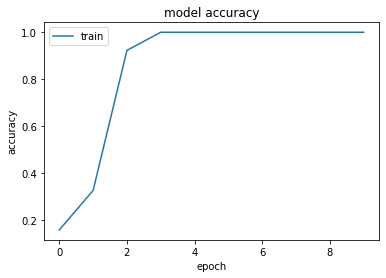

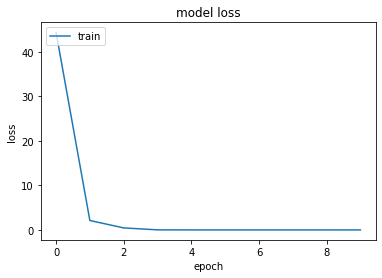

In [172]:
model = clf.export_model()

# Para ver la información de la función summary() que incluye las capas del mejor modelo
model.summary()

#with open('saved/auto_model.pkl', 'wb') as fp:
#        pickle.dump(model, fp)
#        print('Model saved successfully to file')

#print(autohistory.history)
plot_history_2(autohistory)

In [351]:
# Predict with the best model.
test = np.empty([280,832], dtype=int)

test = np.array([io.imread("images/"+p) for p in shoes_test.X.values])

predicted_auto_y = clf.predict(test)


7/7 [==============================] - 13s 2s/step


[2.5702750e-03 2.3256391e-05 1.4227726e-05 3.1008065e-01 5.5854720e-01
 3.2462296e-08 1.9159581e-05 1.1609192e-08 4.3245356e-05 1.2823805e-01
 4.3852815e-13 4.6399565e-04 3.2881038e-09 2.9074989e-12 1.5517179e-10
 9.1684993e-10 8.0422184e-09 1.2539157e-11 8.4346477e-14]


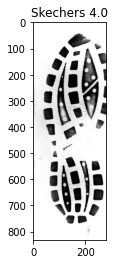

In [352]:
showResult(predicted_y[0],shoes_test.iloc[0], False)

In [353]:
checkAccuracy3First(predicted_auto_y, shoes_test)

10
0.04672897196261682


In [51]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
print(confusion_matrix(shoes_test['y'],predicted_y))


[[ 4  2  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  9  9  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  7  0  0  0  0  2  6  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  2  3  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  1  4  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  2  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0  0 25 19  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  3 87  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  4  5  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  2 13  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  1  0  0

In [202]:

# Evaluate the best model with testing data.
print(clf.evaluate(test, shoes_test['y']))

7/7 [==============================] - 15s 2s/step - loss: 2.6257 - accuracy: 0.4579
[2.6257336139678955, 0.4579439163208008]


Se obtiene una eficacia del 44%, bastante baja respecto a la de entrenamiento.

¿Esto implica sobreentrenamiento?

### Mejoras al modelo propuesto

### Uso de modelo pre-entrenado ImageNet

In [203]:
#https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29

from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input
import ssl
#se usa para evitar el error SSL que lanza VGG16
ssl._create_default_https_context = ssl._create_unverified_context

#vgg16 por defecto usa ImageNet:
modelPre = models.Sequential()
modelPre.add(VGG16(include_top=False, input_shape=(832, 280, 3)))
modelPre.add(Flatten())
modelPre.add(Dense(num_classes))
modelPre.summary()

#inp = Input(shape= (320,872, 3))
#out = VGG16(weights='imagenet')(inp)
#modelPre = Model(inputs=inp, outputs=out)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 26, 8, 512)        14714688  
                                                                 
 flatten_1 (Flatten)         (None, 106496)            0         
                                                                 
 dense_1 (Dense)             (None, 19)                2023443   
                                                                 
Total params: 16,738,131
Trainable params: 16,738,131
Non-trainable params: 0
_________________________________________________________________


In [204]:
import tensorflow as tf
modelPre.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [205]:
preHistory = modelPre.fit(trainGenerator,validation_data=valGenerator, epochs=10)

Epoch 1/10
74/74 [==============================] - 1384s 19s/step - loss: 8.1262 - accuracy: 0.1549 - val_loss: 2.6417 - val_accuracy: 0.2417
Epoch 2/10
74/74 [==============================] - 1390s 19s/step - loss: 2.6574 - accuracy: 0.2106 - val_loss: 2.5986 - val_accuracy: 0.2417
Epoch 3/10
74/74 [==============================] - 1387s 19s/step - loss: 2.6753 - accuracy: 0.2065 - val_loss: 2.5346 - val_accuracy: 0.2417
Epoch 4/10
74/74 [==============================] - 1389s 19s/step - loss: 2.6487 - accuracy: 0.2106 - val_loss: 2.5217 - val_accuracy: 0.2417
Epoch 5/10
74/74 [==============================] - 1358s 18s/step - loss: 2.7624 - accuracy: 0.2038 - val_loss: 2.5445 - val_accuracy: 0.2417
Epoch 6/10
74/74 [==============================] - 1351s 18s/step - loss: 2.7832 - accuracy: 0.1793 - val_loss: 2.7098 - val_accuracy: 0.2417
Epoch 7/10
74/74 [==============================] - 1339s 18s/step - loss: 2.6798 - accuracy: 0.2079 - val_loss: 2.5113 - val_accuracy: 0.2417

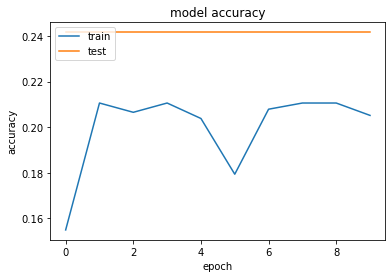

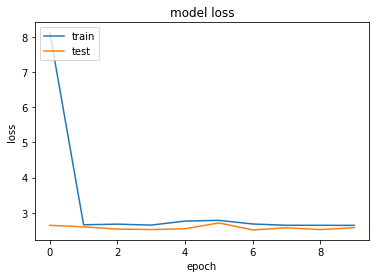

In [206]:
plot_history(preHistory)

Resultados muy bajos para ser con ImageNet.

In [61]:
print(modelPre.evaluate(testGenerator))

30/30 [==============================] - 204s 7s/step - loss: 2.4730 - accuracy: 0.3033
[2.47302508354187, 0.3033333420753479]


In [ ]:
pre_predicted_y = clf.predict(test)

['Asics']


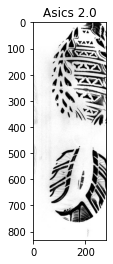

In [207]:
#Mostrar ejemplos
showResult(pre_predicted_y[0],shoes_test.iloc[0], False)

## Análisis de resultados

(TODO)

# Objetivo 2: Búsqueda de similitud (FD300) First try

método No supervisado. 
La idea es crear dos CNN: una codifica las imagenes y la otra las decodifica.

https://github.com/luchonaveiro/image-search-engine/blob/master/02_Train_Autoencoder.ipynb

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Input, Dense, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pickle
import pandas as pd
import tensorflow as tf

# Load images
img_height = 586
img_width = 156
channels = 3
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(
    'fid300/',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     classes=['references'],
     class_mode = 'input',
     subset = 'training',
     shuffle=True)

validation_set = train_datagen.flow_from_directory(
    'fid300/',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     classes=['references'],
     subset = 'validation',
     class_mode = 'input',
     shuffle=False)

#Única clase porque no tengo classes / labels por imagen.

Found 940 images belonging to 1 classes.
Found 235 images belonging to 1 classes.


In [39]:
# Define the autoencoder
input_model = Input(shape=(img_height, img_width, channels))

print(input_model.shape)
# Encoder layers
encoder = Conv2D(32, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(encoder)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder_dim = K.int_shape(encoder)
encoder = Flatten()(encoder)

# Latent Space
latent_space = Dense(16, name='latent_space')(encoder)

# Decoder Layers
decoder = Dense(np.prod(encoder_dim[1:]))(latent_space)
decoder = Reshape((encoder_dim[1], encoder_dim[2], encoder_dim[3]))(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(32, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(3, (3, 3), padding="same")(decoder)
output = Activation('sigmoid', name='decoder')(decoder)

print(output.shape)

(None, 586, 156, 3)
(None, 586, 156, 3)


In [43]:
# Create model object
autoencoder = Model(input_model, output, name='autoencoder')

# Compile the model
autoencoder.compile(loss="mse", optimizer= Adam(learning_rate=1e-3), metrics=['accuracy'])
#autoencoder.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])
# Fit the model
history = autoencoder.fit(
          training_set,
          steps_per_epoch=training_set.n // batch_size,
          epochs=10,
          validation_data=validation_set,
          validation_steps=validation_set.n // batch_size,
          callbacks = [ModelCheckpoint('models/image_autoencoder_2.h5', 
                                       monitor='val_accuracy', 
                                       verbose=0, 
                                       save_best_only=True, 
                                       save_weights_only=False)])
                                       

Epoch 1/10
58/58 [==============================] - 734s 13s/step - loss: 0.0891 - accuracy: 0.3291 - val_loss: 0.1057 - val_accuracy: 0.2088
Epoch 2/10
58/58 [==============================] - 698s 12s/step - loss: 0.0893 - accuracy: 0.3774 - val_loss: 0.1060 - val_accuracy: 0.2388
Epoch 3/10
58/58 [==============================] - 651s 11s/step - loss: 0.0846 - accuracy: 0.3630 - val_loss: 0.0909 - val_accuracy: 0.3906
Epoch 4/10
58/58 [==============================] - 641s 11s/step - loss: 0.0823 - accuracy: 0.3565 - val_loss: 0.0825 - val_accuracy: 0.6320
Epoch 5/10
58/58 [==============================] - 639s 11s/step - loss: 0.0812 - accuracy: 0.3619 - val_loss: 0.0793 - val_accuracy: 0.7355
Epoch 6/10
58/58 [==============================] - 635s 11s/step - loss: 0.0794 - accuracy: 0.3890 - val_loss: 0.0773 - val_accuracy: 0.3434
Epoch 7/10
58/58 [==============================] - 607s 10s/step - loss: 0.0799 - accuracy: 0.4359 - val_loss: 0.0764 - val_accuracy: 0.6251
Epoch 

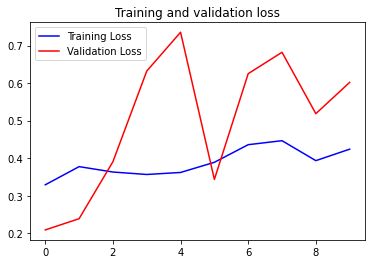

In [52]:
# Plot Accuracy and Loss
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
 
epochs = range(len(loss))
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [55]:
# Predict image function
def predict_image(image_dir, autoencoder):
  raw_image = load_img(image_dir, target_size=(img_height, img_width))
  image = img_to_array(raw_image)
  image = np.expand_dims(image, axis=0)
  image = image / 255.0
  pred = autoencoder.predict(image)
  pred = pred * 255.0
  pred = np.reshape(pred, (img_height, img_width, 3))
  pred = array_to_img(pred)

  return raw_image, pred



1/1 [==============================] - 0s 407ms/step


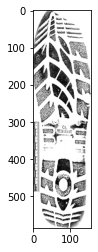

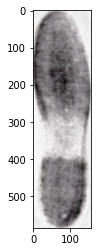

1/1 [==============================] - 0s 382ms/step


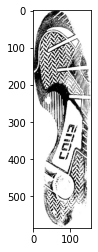

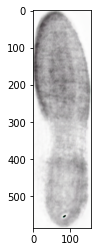

1/1 [==============================] - 0s 396ms/step


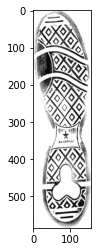

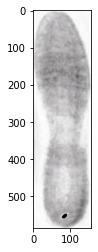

In [56]:
# Predict 3 images from training set
train_imgs = training_set.filepaths[0:3]

for i in train_imgs:
  raw_image, pred_image = predict_image(i, autoencoder)
  
  # Show original image
  plt.imshow(raw_image)
  plt.show()
  
  # Show predicted image
  plt.imshow(pred_image)
  plt.show()

In [59]:
import os
#
latent_space_model = Model(
                      autoencoder.input, 
                      autoencoder.get_layer('latent_space').output)
#
# Load all images and predict them with the latent space model
X = []
indices = []

for i in tqdm(range(len(os.listdir('./fid300/references')))):
  try:
    img_name = os.listdir('./fid300/references')[i]
    img = load_img('./fid300/references/{}'.format(img_name), 
                   target_size = (img_height, img_width))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    pred = latent_space_model.predict(img)
    pred = np.resize(pred, (16))
    X.append(pred)
    indices.append(img_name)

  except Exception as e:
    print(img_name)
    print(e)

    # Export the embeddings
embeddings = {'indices': indices, 'features': np.array(X)}
pickle.dump(embeddings, 
            open('./fid300/image_embeddings.pickle', 'wb'))
#
def eucledian_distance(x,y):
  eucl_dist = np.linalg.norm(x - y)
  return eucl_dist



<ipython-input-59-9259c5b0dfc3>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(os.listdir('./fid300/references')))):


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 60ms/step



In [60]:
# Load embeddings
embeddings = pickle.load(open('./fid300/image_embeddings.pickle', 'rb'))

# Load images metadata
metadata = pd.read_csv('data/FID300/label_table.csv')

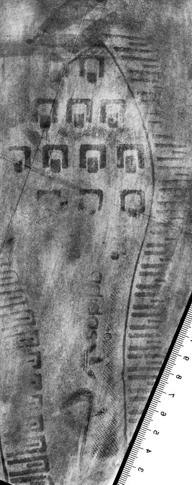

In [68]:
# Get image name
img_name = os.listdir('./fid300/tracks_cropped')[3]
img = load_img('./fid300/tracks_cropped/{}'.format(img_name))
img

In [69]:
# Calculate eucledian distance
img_similarity = []
cat_similarity = []

# Get actual image embedding
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)
pred = latent_space_model.predict(img)
pred = np.resize(pred, (16))
ref_image = metadata.query("X == '{}'".format(int(img_name.replace('.jpg',''))))['y'].values[0]
print('Image Category: {}'.format(img_cat))

for i in tqdm(range(len(embeddings['indices']))):
  img_name = embeddings['indices'][i]

  # Calculate vectors distances
  dist = eucledian_distance(pred,embeddings['features'][i])
  img_similarity.append(dist)

  # Calculate categoy similarity
  #cat = metadata.query("id == '{}'".format(img_name.replace('.jpg','')))['category'].values[0]
  #cat_sim = category_similarity(img_cat, cat)
  #cat_similarity.append(cat_sim)

imgs_result = pd.DataFrame({'img': embeddings['indices'],
                            'euclidean_distance': img_similarity})


imgs_result = imgs_result.query('euclidean_distance > 0').sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)
#imgs_result = imgs_result.iloc[0:20,:].sort_values(by='category_similarity', ascending=False).reset_index(drop=True)

# Show 10 first similar images
for i in range(3):
  image = load_img('./fid300/references/{}'.format(imgs_result['img'].values[i]))
  #category = metadata.query("id == '{}'".format(imgs_result['img'].values[i].replace('.jpg','')))['category'].values[0]
  
  # Show image
  plt.imshow(image)
  plt.show()
  print('Image Name: {}'.format("NAME"))
  print('Euclidean Distance: {}'.format(imgs_result['euclidean_distance'].values[i]))
  #print('Category Distance: {}'.format(imgs_result['category_similarity'].values[i]))

InvalidArgumentError: Graph execution error:

Detected at node 'model_2/flatten_9/Reshape' defined at (most recent call last):
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/runpy.py", line 193, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/traitlets/config/application.py", line 664, in launch_instance
      app.start()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 583, in start
      self.io_loop.start()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 149, in start
      self.asyncio_loop.run_forever()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/ioloop.py", line 690, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/ioloop.py", line 743, in _run_callback
      ret = callback()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 787, in inner
      self.run()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 748, in run
      yielded = self.gen.send(value)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
      yielded = next(result)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
      yielded = next(result)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
      yielded = next(result)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2857, in run_cell
      result = self._run_cell(
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
      return runner(coro)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3062, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-69-04d09a17272a>", line 8, in <module>
      pred = latent_space_model.predict(img)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
      return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/layers/reshaping/flatten.py", line 104, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'model_2/flatten_9/Reshape'
Input to reshape is a tensor with 5959680 values, but the requested shape requires a multiple of 5850624
	 [[{{node model_2/flatten_9/Reshape}}]] [Op:__inference_predict_function_138208]

# Analisis de resultados
